# Spatial random forest for flood prediction
Outcome variable: `flood` represents presence/absence of flood in pixel (slightly misleading name.)


Slightly dodgy, but modified this file to get rid of the annoying ImportError: Numba needs NumPy 1.21 or less. <br> _'~/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/numba/__init__.py'_ <br>
changed line 139 from ```elif numpy_version > (1, 21):``` to ```elif numpy_version > (1, 23):```
Seems okay so far...

In [1]:
RUNNAME = 'MENABE_AND_CUBA'  # leave blank for run not being saved

In [2]:
# general imports
from os.path import join
from os import mkdir
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import logging
from datetime import datetime

# machine learning imports
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix as cm
from sklearn.inspection import permutation_importance

# plotting imports
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter

# helper function imports
from importlib import reload
import model_utils
import data_utils
import viz_utils
from viz_utils import soge_colours

# fix for local issue with multiple proj installations
import pyproj
pyproj.datadir.get_data_dir()  # '/Users/alison/miniconda3/share/proj'
pyproj.datadir.set_data_dir('/Users/alison/miniconda3/envs/hybridmodels-modelbuild/share/proj')
pyproj.datadir.get_data_dir()

# ignore annoying FutureWarning in RandomForest cell
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# set up the environment
wd = join("..", "data")
imdir = join(wd, 'images')
logdir = join("logfiles")

# create logging to file
logger = logging.getLogger("rf_spatial")
logger.setLevel(logging.INFO)
fh = logging.FileHandler(join(logdir, "rf_spatial.log"), mode='a')
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s, %(levelname)s: %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

# folder for image results of this run
runtime = datetime.now()
try:
    mkdir(join(imdir, 'rf_spatial', RUNNAME))
except Exception as e:
    print(e)
    
    
def add_feature_label(feature):
    if '_spatial' in feature:
        string = feature.replace('_spatial', '')
        string = viz_utils.labels[string]
        string = ' '.join([string, 'spatial']) 
    elif '_to_pw' in feature:
        string = feature.replace('_to_pw', '')
        string = viz_utils.labels[string]
        string = ' '.join([string, 'to pw']) 
    else:
        string = viz_utils.labels[feature]
    return string

# settings
viz = True
storm = "gombe"  # e.g., "roanu" or "" for all events
temporal = False
binary = True
floodthresh = 0.5

test_event = 'roanu_barguna_0'  # TODO: use more than one
logthisrun = True

## Load  data: TODO

In [14]:
reload(model_utils)
gdf = model_utils.load_spatial_data(wd)

## Process data

In [15]:
"""
Process features for machine learning - order of functions matters here.

Add the functions to model_utils.py later
"""

reload(model_utils)
SEED = 1
print(f"Initial length of dataframe: {len(gdf)}")

# remove features
def remove_feature(to_remove, columns, notes):
    if "transforms" not in gdf.attrs:
        gdf.attrs['transforms'] = {}
        
    for feature in to_remove:
        columns.remove(feature)
        notes.append(f'{feature} excluded')
        gdf.attrs['transforms'][feature] = ['removed']
    return columns, notes


# NEW: summarise LULC data
def summarise_lulc(gdf, columns, features_binary, features_continuous, notes):
    """Summarise LULC into four categories."""
        
    # set up lulc dict
    lulc_summary = {value: key for key, values in model_utils.lulc_categories.items() for value in values}
    lulc_summary_spatial = {f'{key}_spatial': f'{value}_spatial' for key, value in lulc_summary.items()}
    lulc_summary = lulc_summary | lulc_summary_spatial
    
    # change gdf
    lulc_cols = [key for key in model_utils.lulc_categories.keys()]
    lulc_cols += [f'{key}_spatial' for key in lulc_cols]
    gdf = gdf.rename(columns=lulc_summary)
    gdf_lulc = gdf[lulc_cols].groupby(level=0, axis=1).any().astype(float)
    gdf = gdf.drop(columns=lulc_cols)# .join(gdf_lulc)
    gdf[lulc_cols] = gdf_lulc[lulc_cols]
    
    # change corresponding variables
    columns = [*set(lulc_summary[x] if x in lulc_summary.keys() else x for x in columns)]
    features_binary = [*set(lulc_summary[x] if x in lulc_summary.keys() else x for x in features_binary)]
    features_continuous = [*set(lulc_summary[x] if x in lulc_summary.keys() else x for x in features_continuous)]
    nfeatures = len(features_binary) + len(features_continuous)
    
    # make note of changes
    if "transforms" not in gdf.attrs:
        gdf.attrs['transforms'] = {}
    if 'lulc' not in gdf.attrs['transforms']:
        gdf.attrs['transforms']['lulc'] = []
    gdf.attrs['transforms']['lulc'].append('summarised into three categories')
    notes.append('summarised lulc columns into three categories')
    
    return gdf, columns, features_binary, features_continuous, nfeatures, notes

# random undersampling
def random_undersample(gdf, notes, columns, SEED):
    
    gdf_flood = gdf[gdf.floodfrac==1]
    gdf_noflood = gdf[gdf.floodfrac==0]
    gdf_noflood = gdf_noflood.sample(n=n1, random_state=SEED)
    gdf_undersampled = pd.concat([gdf_flood, gdf_noflood])
    gdf_undersampled = gdf_undersampled[columns]
    
    # make note of changes
    if "transforms" not in gdf.attrs:
        gdf.attrs['transforms'] = {}
    gdf_undersampled.attrs = gdf.attrs
    if 'general' not in gdf_undersampled.attrs['transforms']:
        gdf_undersampled.attrs['transforms']['general'] = []
    gdf_undersampled.attrs['transforms']['general'].append('undersampled to same number of flood and non-flood.')
    notes.append('undersampled to same number of flood and non-flood pixels')
    
    return gdf_undersampled, notes
                 

# columns
notes = []
columns = [*gdf.columns]
to_remove = ['lulc__40', 'lulc__40_spatial']
columns, notes = remove_feature(to_remove, columns, notes)
                 
# feature columns             
features = columns.copy()
features.remove('geometry')
features.remove('floodfrac')
features.remove('event')
nfeatures = len(features)

# sort binary and continuous features
features_binary, features_continuous = data_utils.split_features_binary_continuous(data_utils.binary_keywords, features)

# NEW: summarise LULC columns
gdf, columns, features_binary, features_continuous, nfeatures, notes = summarise_lulc(gdf, columns, features_binary, features_continuous, notes)
features = features_binary + features_continuous
print(f"After summarising LULC length: {len(gdf)}")

# binarise binary features
thresh = floodthresh
for feature in features_binary:
    gdf[feature] = gdf[feature].apply(lambda x: 1 if x > thresh else 0).astype(int)

# remove permanent water cells
gdf = gdf[gdf['dist_pw']>0]
notes.append('removed permanent water grid cells')


# normalise continuous features
gdf_normalised = gdf.copy(deep=True)
for feature in features_continuous:
    gdf_normalised = model_utils.normalise_feature(gdf_normalised, feature)
print(f"After normalisation length: {len(gdf_normalised)}")
# check what's been normalised: gdf_normalised.attrs

# remove test event from data for testing and plotting later
gdf_test_unseen = gdf_normalised[gdf_normalised['event'] == test_event]
gdf_normalised = gdf_normalised[~(gdf_normalised['event'] == test_event)]
gdf_test_unseen = gpd.overlay(gdf_test_unseen, gdf_normalised, how='difference')  # remove any overlapping bits

# random undersampling
global n, n1, n0
n = len(gdf)
n1 = gdf['floodfrac'].sum()
n0 = n - n1
gdf_normalised, notes = random_undersample(gdf_normalised, notes, columns, SEED)

gdf_normalised = gdf_normalised.replace(np.nan, 0.)
gdf_normalised['floodfrac'] = gdf_normalised['floodfrac'].astype(int)

print(f"After undersampling length: {len(gdf_normalised)}")
print(f"Number of ones: {gdf_normalised['floodfrac'].sum()}")
print(f"Number of zeros: {gdf_normalised['floodfrac'].count() - gdf_normalised['floodfrac'].sum()}")

print(f"\nNotes:\n\n{notes}")

Initial length of dataframe: 188416
After summarising LULC length: 188416
After normalisation length: 72871
After undersampling length: 26537
Number of ones: 12441
Number of zeros: 14096

Notes:

['lulc__40 excluded', 'lulc__40_spatial excluded', 'summarised lulc columns into three categories', 'removed permanent water grid cells', 'undersampled to same number of flood and non-flood pixels']


Text(0.5, 1.0, 'Unseen region: roanu_barguna_0')

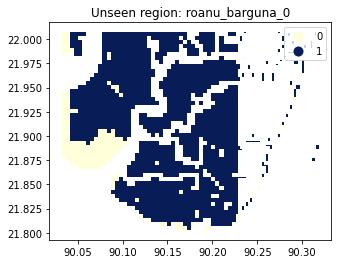

In [16]:
gdf_test_unseen.plot('floodfrac', cmap="YlGnBu", legend=True)
plt.title(f'Unseen region: {test_event}')

# Random Forest: model
## Cross-validate results with the tuned hyperparameters

In [30]:
from tqdm.notebook import tqdm

run_rf = True

if run_rf:
    K = 5  # number of folds to use
    best_params = np.load('best_params_rf.npy', allow_pickle=True).item()

    X, y = gdf_normalised[features + ['event', 'geometry']], gdf_normalised['floodfrac']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    # separate from data for plotting later
    X_train_toview = X_train.copy(deep=True)
    X_test_seen = X_test.copy(deep=True)
    
    X_train = X_train[features]
    X_test = X_test[features]

    cv = KFold(n_splits=K, random_state=SEED, shuffle=True)

    CSIs = []
    TPs = []
    FPs = []
    TNs = []
    FNs = []
    rankings = []

    for train_index, val_index in tqdm(cv.split(X_train)):
        Xf_train, Xf_test = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
        yf_train, yf_test = y_train[train_index], y_train[val_index]

        rf = RandomForestClassifier(random_state=SEED, **best_params)
        rf.fit(Xf_train, yf_train)
        yf_pred = rf.predict(Xf_test)  # sample_weight=None

        confusion_matrix = cm(yf_test, yf_pred)

        if confusion_matrix.shape == (2, 2):
            TP = confusion_matrix[1, 1]
            FP = confusion_matrix[0, 1] #(row, col) = (true, pred)
            FN = confusion_matrix[1, 0]
            TN = confusion_matrix[0, 0]

            TPs.append(TP)
            FPs.append(FP)
            FNs.append(FN)
            TNs.append(TN)

            CSI = TP / (TP + FP + FN)  # critical success index
            CSIs.append(CSI)

        rankings.append(pd.Series(rf.feature_importances_, index=features))

0it [00:00, ?it/s]

In [31]:
print(f"mean of training CSIs: {np.mean(CSIs):.02%}")
print(f"std. of training CSIs: {np.std(CSIs):.02%}")

mean of training CSIs: 83.88%
std. of training CSIs: 0.95%


## Evaluate on test set in seen location

In [32]:
from matplotlib.colors import ListedColormap
from viz_utils import soge_colours

def get_csi(y_test, y_pred):
    """Return CSI and relevant metrics for two arrays."""
    confusion_matrix = cm(y_test, y_pred)
    if confusion_matrix.shape == (2, 2):
        TP = confusion_matrix[1, 1]
        FP = confusion_matrix[0, 1] #(row, col) = (true, pred)
        FN = confusion_matrix[1, 0]
        TN = confusion_matrix[0, 0]
        CSI = TP / (TP + FP + FN)  # critical success index / IoU / Jaccard Index
        
        return CSI, TP, FP, FN, TN
    
def confusion_label(y_test, y_pred):
    """Assign confusion label to a (true, predicted) pair."""
    if y_pred + y_test == 2:
        return 'TP'
    elif y_pred + y_test == 0:
        return 'TN'
    elif (y_test == 0) and (y_pred == 1):
        return 'FP'
    elif (y_test == 1) and (y_pred == 0):
        return 'FN'
    else:
        print(f"ISSUE: {y_test}, {y_pred}")
        return ''

In [33]:
# train the model on the full test set
rf.fit(X_train, y_train)

# predictions for the test set
y_pred = rf.predict(X_test)
CSI_test_seen, _, _, _, _ = get_csi(y_test, y_pred)
print(f"CSI for seen test region: {CSI_test_seen:.02%}")

CSI for seen test region: 85.80%


/var/folders/pw/g3l12fr515df7s6dpdch4qx00000gn/T/ipykernel_91846/1488589941.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X_test_event = X_test_event.set_geometry(X_test_event.centroid)
/var/folders/pw/g3l12fr515df7s6dpdch4qx00000gn/T/ipykernel_91846/1488589941.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X_test_event = X_test_event.set_geometry(X_test_event.centroid)
/var/folders/pw/g3l12fr515df7s6dpdch4qx00000gn/T/ipykernel_91846/1488589941.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X_test_event = X_test_event.set_geometry(X_test_event.centroid

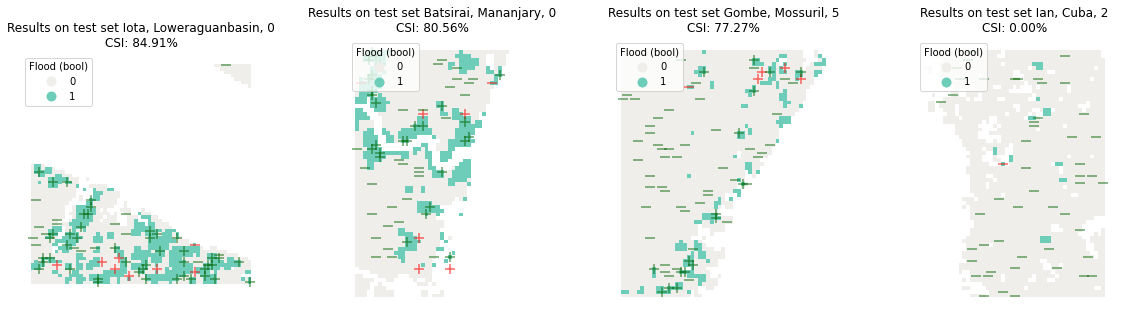

In [40]:
# process data to view single event
X_test_seen[f'flood_true'] = y_test
X_test_seen[f'flood_pred'] = y_pred
X_test_seen['confusion'] = X_test_seen[[f'flood_true', f'flood_pred']].apply(lambda row: confusion_label(row[f'flood_true'], row[f'flood_pred']), axis=1)
events = X_test_seen['event'].unique()

# loop through events
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, event_to_view in enumerate(events[[0, 1, 2, 4]]):
    
    # subset event and calculate csi
    X_test_event = X_test_seen[X_test_seen['event'] == event_to_view]
    X_test_event = X_test_event.set_geometry(X_test_event.centroid)
    csi_test_seen, _, _, _, _ = get_csi(X_test_event[f'flood_true'], X_test_event[f'flood_pred'])

    # set up colors and markerstyles
    bg_cmap = ListedColormap([soge_colours['beige'], soge_colours['light turquoise']])
    markerstyles = {'TP': '+', 'FP': '+', 'TN': '_', 'FN': '_'}
    markercolors = {'TP': 'darkgreen', 'FP': 'red', 'TN': 'darkgreen', 'FN': 'red'}
    X_test_pos = X_test_event[X_test_event.confusion.isin(['TP', 'FP'])]
    X_test_neg = X_test_event[X_test_event.confusion.isin(['TN', 'FN'])]
    bg = gdf[gdf['event'] == event_to_view]

    # plot background and test set points
    bg.plot('floodfrac', categorical=True, cmap=bg_cmap, ax=axs[i], legend=True,
            legend_kwds={'title': 'Flood (bool)', 'loc': 'upper left'})

    X_test_pos.plot(color=X_test_pos['confusion'].map(markercolors), alpha=0.6,
                    marker='+',  markersize=100, ax=axs[i], categorical=True)

    X_test_neg.plot(color=X_test_neg['confusion'].map(markercolors), alpha=0.6,
                      marker='_',  markersize=100, ax=axs[i], categorical=True)
    
    axs[i].set_title(f"Results on test set {', '.join([x.capitalize() for x in event_to_view.split('_')])}\nCSI: {csi_test_seen:.2%}")
    

for ax in axs:
    # clean up axses
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

fig.savefig(join(imdir, 'rf_spatial', 'test_set_results.png'), dpi=500, bbox_inches='tight')
fig.savefig(join(imdir, 'rf_spatial', RUNNAME, 'test_set_results.png'), dpi=500, bbox_inches='tight')

## Feature rankings
1. Impurity-based importance
2. [Permutation-based importances](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

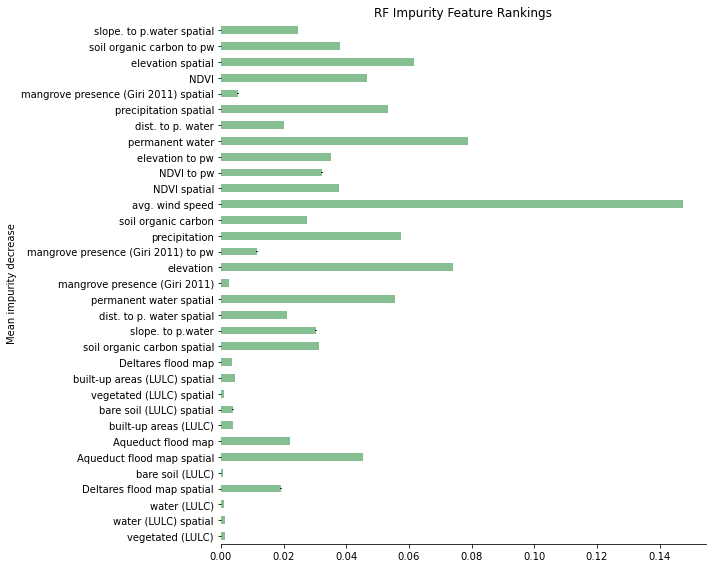

In [41]:
# impurity-based importances
reload(viz_utils)
runme = True
savefig = True

if runme:
    stds = [np.std([rank[feature] for rank in rankings]) for feature in features]
    means = [np.mean([rank[feature] for rank in rankings]) for feature in features]

    mean_rankings = pd.Series(means, index=features)
    mean_rankings = mean_rankings.rename(index=add_feature_label)

    fig, ax = plt.subplots(figsize=(10, 8))
    mean_rankings.plot.barh(yerr=stds, ax=ax, color='#86bf91')
    ax.set_title("RF Impurity Feature Rankings")
    ax.set_ylabel("Mean impurity decrease")
    fig.tight_layout()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if savefig:
        fig.savefig(join(imdir, "rf_spatial", f"RF impurity feature rankings temporal{temporal}"), dpi=500)
        fig.savefig(join(imdir, "rf_spatial", RUNNAME, f"RF impurity feature rankings temporal{temporal}"), dpi=500)

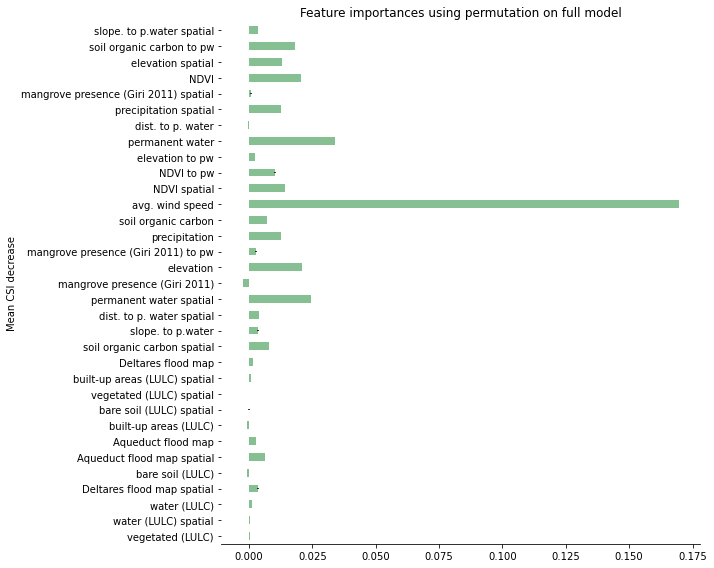

In [42]:
# permuatation importances
run_pis = True

# use critical success index to evaluate model according to scorer
def csi(y_true, y_pred):
    """Critical success index"""
    confusion_matrix = cm(y_true, y_pred)
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1] #(row, col) = (true, pred)
    FN = confusion_matrix[1, 0]
    csi = TP / (TP + FP + FN)  # critical success index
    return csi

def evaluate(model, test_features, test_labels):
    test_predictions = model.predict(test_features)
    csi_val = csi(test_labels, test_predictions)
    print('Model Performance')
    print('CSI = {:0.2f}%.'.format(csi_val))  # should * 100 for next run
    
    
    return csi_val

csi_scorer = make_scorer(csi)

if run_pis:
    savefig = True

    best_params = np.load('best_params_rf.npy', allow_pickle=True).item()
    pi = permutation_importance(rf, X_test, y_test, scoring=csi_scorer, random_state=SEED)
    mean_pis = pd.Series(pi.importances_mean, index=features)
    mean_pis = mean_pis.rename(index=add_feature_label)


    fig, ax = plt.subplots(figsize=(10, 8))
    mean_pis.plot.barh(yerr=pi.importances_std, ax=ax, color='#86bf91')
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean CSI decrease")
    fig.tight_layout()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if savefig:
        fig.savefig(join(imdir, "rf_spatial", f"RF permutation feature rankings temporal{temporal}"), dpi=500)
        fig.savefig(join(imdir, "rf_spatial", RUNNAME, f"RF permutation feature rankings temporal{temporal}"), dpi=500)

# Evaluate on an unseen subregion

In [44]:
# view predictions on the test event
plt.rcParams['font.family'] = 'Arial'
#gdf_test_unseen['flood'] = gdf_test_unseen['flood'].apply(lambda x: 0 if x=='No flood' else 1)
gdf_test_unseen['floodfrac'] = gdf_test_unseen['floodfrac'].astype(int)
X_test_event, y_test_event = gdf_test_unseen[features], gdf_test_unseen['floodfrac']
y_pred_event = rf.predict(X_test_event)

confusion_matrix = cm(y_test_event, y_pred_event)

TP_test = confusion_matrix[1, 1]
FP_test = confusion_matrix[0, 1]
FN_test = confusion_matrix[1, 0]
TN_test = confusion_matrix[0, 0]

CSI_test_unseen = TP_test / (TP_test + FP_test + FN_test)  # critical success index

In [46]:
y_true_event = gdf_test_unseen['floodfrac'].to_numpy()
gdf_test_unseen['flood_pred'] = y_pred_event
gdf_test_unseen['error_type'] = gdf_test_unseen[['floodfrac', 'flood_pred']].apply(lambda row: confusion_label(row[0], row[1]), axis=1)

# make flood categorical for plotting
gdf_test_unseen['floodfrac'] = gdf_test_unseen['floodfrac'].apply(lambda x: 'No flood' if x==0 else 'Flood')
gdf_test_unseen['flood_pred'] = gdf_test_unseen['flood_pred'].apply(lambda x: 'No flood' if x==0 else 'Flood')

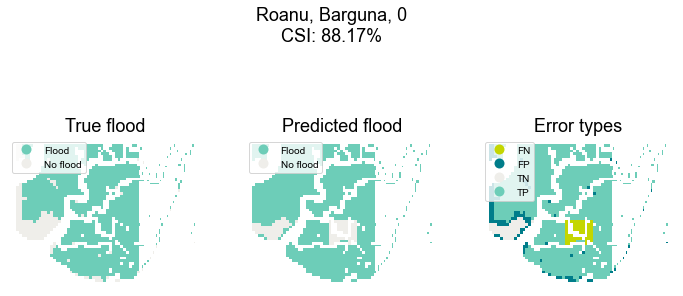

In [48]:
# colormap
cmap= ListedColormap([soge_colours['light turquoise'], soge_colours['beige']])
cm_categories = ListedColormap([soge_colours['yellowish green'], soge_colours['medium turquoise'],
                                soge_colours['beige'], soge_colours['light turquoise']])

# labels
labels = np.array(["No Flood", "Flood"])
len_lab = len(labels)

# plot
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

gdf_test_unseen.plot('floodfrac', ax=axs[0], categorical=True, cmap=cmap,
                      legend=True, legend_kwds={'loc': 'upper left'})
gdf_test_unseen.plot('flood_pred', ax=axs[1], categorical=True, cmap=cmap,
                      legend=True, legend_kwds={'loc': 'upper left'})
gdf_test_unseen.plot('error_type', categorical=True, cmap=cm_categories,
                      legend=True, legend_kwds={'loc': 'upper left'}, ax=axs[2])


fig.suptitle(f"{', '.join([x.capitalize() for x in test_event.split('_')])}\nCSI: {CSI_test_unseen:.2%}",
             fontsize=18);

axs[0].set_title('True flood', fontsize=18)
axs[1].set_title('Predicted flood', fontsize=18)
axs[2].set_title('Error types', fontsize=18)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# format output png and save
outpath = join(imdir, 'rf_spatial', f'unseen_region.png')
fig.savefig(outpath, bbox_inches='tight', dpi=500)
outpath = join(imdir, 'rf_spatial', RUNNAME, f'unseen_region.png')
fig.savefig(outpath, bbox_inches='tight', dpi=500)

## Log the results

In [49]:
logthisrun = True

In [50]:
if logthisrun:
    logger.info("NEW RUN")
    logger.info(f"Loading data with:\ntemporal={temporal},\nbinary={binary} with thresh. {floodthresh},\nstorm subset: {storm}")
    logger.info(f"Run with {nfeatures} features: {features}")
    logger.info(f"Number of unique images/subregions: {gdf_normalised['event'].nunique()}")
    logger.info(f"Notes: {notes}")

    logger.info(f"Zeros: {n0}")
    logger.info(f"Ones: {n1}")

    logger.info(f"Starting {K}-fold CV with seed={SEED}")
    logger.info(f"Running random forest with params:\n{best_params}")

    logger.info(f"Mean CSI: {np.mean(CSIs):.2%}")
    logger.info(f"CSI Std. Dev.: {np.std(CSIs):.2%}")
    logger.info(f"CSI on test set: {CSI_test_seen:.2%}")
    logger.info(f"CSI on unseen subregion {test_event}: {CSI_test_unseen:.2%}")
    logger.info(f"Results for {test_event.replace('_', ' ')} in {outpath}")

    logger.info(f"Impurity-based importance: mean rankings:\n{mean_rankings}")
    if run_pis:
        logger.info(f"Permutation-based importance: mean rankings:\n{mean_pis}")

    logger.info("END OF RUN\n\n\n")
    
    
    
    # add to the metrics csv
    metrics_dict = {
        'date': runtime.strftime("%Y-%m-%d %Hh%Mm"),
        'runname': RUNNAME,
        'notes': [notes],
        'temporal': 'True' if temporal else 'False',
        'binary': floodthresh if binary else 'False',
        'nevents': gdf_normalised['event'].nunique(),
        'nfeatures': nfeatures,
        'features': [[*features]],
        'nzeros': n0,
        'nones': n1,
        'folds': K,
        'SEED': SEED,
        'best_params': [best_params],
        'mean train CSI': np.mean(CSIs),
        'std train CSIs': np.std(CSIs),
        'test CSI (seen)': CSI_test_seen,
        'test CSI (unseen)': CSI_test_unseen,
        'impurity-based rankings': [[*mean_rankings.index]],
        'impurity-based scores': [mean_rankings.values],
        'perm-based rankings': [[*mean_pis.index]] if run_pis else "not done",
        'perm-based scores': [mean_pis.values],
        'results folder': outpath
    }

    all_metrics = pd.read_csv(join(wd, 'images', 'rf_spatial', 'metrics.csv')).astype(str)
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='columns', dtype='object').astype(str)
    new_metrics = all_metrics.append(metrics_df)
    new_metrics = new_metrics.drop_duplicates()
    new_metrics.to_csv(join(wd, 'images', 'rf_spatial', 'metrics.csv'), index=False)

In [51]:
new_metrics[['runname', 'mean train CSI', 'std train CSIs', 'test CSI (seen)',
       'test CSI (unseen)']]

,runname,mean train CSI,std train CSIs,test CSI (seen),test CSI (unseen)
0,thresh 0.0,0.8784975971985883,0.0032572083187456,0.8633268482490273,0.3847874720357941
1,thresh 0.5,0.8781328879785454,0.002977378219009,0.8644314868804664,0.397752808988764
2,Remove water cells,0.826705771495536,0.0054892480835855,0.8263473053892215,0.2608695652173913
3,intermediate wet-dry features,0.8222566408945449,0.0065548973570173,0.8237243207422134,0.2489082969432314
4,intermediate wet-dry features with rai hinunangan,0.8237428452922126,0.0094660482739594,0.8326822916666666,0.0894941634241245
5,intermediate wet-dry features with roanu bargu...,0.8100833843633695,0.0097206055029723,0.8081805359661495,0.8889645776566758
0,MENABE_AND_CUBA,0.8388113593109725,0.009477299601944765,0.8579838116261957,0.8816768086544963


In [63]:
! say done

# Hyperparameter Tuning (Optional)
## 1. Random CV
From [this tutorial](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# set up random grid search
randomcv = False

# look at base case
SEED = 1
rf = RandomForestClassifier(random_state=SEED)

# train-test split
X, y = gdf_normalised[features], gdf_normalised['flood']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

if randomcv:
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]


    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    pprint(random_grid)
    
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                                   cv=3, scoring=csi_scorer, verbose=2, random_state=42, n_jobs=-1)

    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

    np.save('best_params_rf.npy', grid_search.best_params_) 
    
    
    base_model = RandomForestClassifier(random_state=SEED)
    base_model.fit(X_train, y_train)
    base_csi = evaluate(base_model, X_test, y_test)

    best_random = grid_search.best_estimator_
    random_csi = evaluate(best_random, X_test, y_test)

    print('Improvement of {:0.2f}%.'.format( 100 * (random_csi - base_csi) / base_csi))

    !say done

## 2. Grid Search

In [ ]:
gridsearch = False

if gridsearch:
    from sklearn.model_selection import GridSearchCV
    # Create the parameter grid based on the results of random search 
    param_grid = {
        'bootstrap': [False],
        'max_depth': [40, 45, 50, 55, 60],
        'max_features': ['auto'],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [1, 2, 3],
        'n_estimators': [500, 1000, 1500]
    }

    # Create a based model
    rf = RandomForestClassifier(random_state=SEED)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=csi_scorer, 
                              cv=3, n_jobs=-1, verbose=2)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

    np.save('best_params_rf.npy', grid_search.best_params_) 